# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


In [2]:
# Load dataset
df = pd.read_csv("all_songsml.csv")

# Drop rows with missing values
df = df.dropna()

# Select features and target
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness',
        'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 
        'explicit', 'is_collaboration']]
y = df['is_billboard']

# Create a copy of the original data (no balancing applied)
X_complete = X
y_complete = y

# 1:1 Undersampled Dataset (equal number of hits and non-hits)
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=21)
X_undersampled, y_undersampled = rus.fit_resample(X, y)

# Hybrid Dataset (uses both undersampling and SMOTE for balance)
# Step 1: Undersample majority class to get 1:4 ratio
rus_hybrid = RandomUnderSampler(sampling_strategy=0.25, random_state=21)
X_hybrid_under, y_hybrid_under = rus_hybrid.fit_resample(X, y)

# Step 2: Use SMOTE to oversample minority class to 1:2 ratio
smote = SMOTE(sampling_strategy=0.5, random_state=21)
X_hybrid, y_hybrid = smote.fit_resample(X_hybrid_under, y_hybrid_under)

# Split each dataset into training and testing sets (80/20 split)
X_train_complete, X_test_complete, y_train_complete, y_test_complete = train_test_split(
    X_complete, y_complete, test_size=0.2, random_state=21, stratify=y_complete)

X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(
    X_undersampled, y_undersampled, test_size=0.2, random_state=21, stratify=y_undersampled)

X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
    X_hybrid, y_hybrid, test_size=0.2, random_state=21, stratify=y_hybrid)

# Print value counts for each dataset
print("Complete Dataset Count:")
print(y_complete.value_counts())

print("\n1:1 Undersampled Dataset Count:")
print(y_undersampled.value_counts())

print("\nHybrid Dataset Count:")
print(y_hybrid.value_counts())

Complete Dataset Count:
is_billboard
0    894392
1     20402
Name: count, dtype: int64

1:1 Undersampled Dataset Count:
is_billboard
0    20402
1    20402
Name: count, dtype: int64

Hybrid Dataset Count:
is_billboard
0    81608
1    40804
Name: count, dtype: int64


# Models

# Complete Dataset

### Random Forest

In [3]:
# Random Forest: Complete Dataset

rf_complete = RandomForestClassifier(random_state=21)
rf_complete.fit(X_train_complete, y_train_complete)

y_pred_complete = rf_complete.predict(X_test_complete)

print("=== Random Forest: Complete Dataset ===")
print("Accuracy:", accuracy_score(y_test_complete, y_pred_complete))
print(classification_report(y_test_complete, y_pred_complete))
print("Confusion Matrix:\n", confusion_matrix(y_test_complete, y_pred_complete))

=== Random Forest: Complete Dataset ===
Accuracy: 0.9763772211260446
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    178879
           1       0.00      0.00      0.00      4080

    accuracy                           0.98    182959
   macro avg       0.49      0.50      0.49    182959
weighted avg       0.96      0.98      0.97    182959

Confusion Matrix:
 [[178637    242]
 [  4080      0]]


### Random Forest (Optimized)

In [4]:
# Optimized Random Forest: Complete Dataset
# Using class_weight and a lower threshold to catch more hits

rf_optimized = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=21
)

rf_optimized.fit(X_train_complete, y_train_complete)

# Predict probabilities and apply custom threshold (0.25)
y_probs_rf = rf_optimized.predict_proba(X_test_complete)[:, 1]
y_pred_rf_opt = (y_probs_rf > 0.25).astype(int)

print("\n=== Optimized Random Forest: Complete Dataset ===")
print("Accuracy:", accuracy_score(y_test_complete, y_pred_rf_opt))
print(classification_report(y_test_complete, y_pred_rf_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test_complete, y_pred_rf_opt))


=== Optimized Random Forest: Complete Dataset ===
Accuracy: 0.9648719111932181
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    178879
           1       0.08      0.06      0.07      4080

    accuracy                           0.96    182959
   macro avg       0.53      0.52      0.53    182959
weighted avg       0.96      0.96      0.96    182959

Confusion Matrix:
 [[176297   2582]
 [  3845    235]]


### XgBoost (Standard)

In [5]:
# XGBoost: Complete Dataset

xgb_complete = XGBClassifier(random_state=21)
xgb_complete.fit(X_train_complete, y_train_complete)

y_pred_xgb = xgb_complete.predict(X_test_complete)

print("\n=== XGBoost: Complete Dataset ===")
print("Accuracy:", accuracy_score(y_test_complete, y_pred_xgb))
print(classification_report(y_test_complete, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test_complete, y_pred_xgb))


=== XGBoost: Complete Dataset ===
Accuracy: 0.9776999218404123
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    178879
           1       0.00      0.00      0.00      4080

    accuracy                           0.98    182959
   macro avg       0.49      0.50      0.49    182959
weighted avg       0.96      0.98      0.97    182959

Confusion Matrix:
 [[178879      0]
 [  4080      0]]


c:\Users\Joseph Romero IV\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Joseph Romero IV\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Joseph Romero IV\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### XgBoost (Optimized)

In [6]:
# Optimized XGBoost: Complete Dataset
# Tuning class weight and threshold

xgb_optimized = XGBClassifier(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=15,
    scale_pos_weight=50,
    random_state=21
)

xgb_optimized.fit(X_train_complete, y_train_complete)

# Predict probabilities and apply threshold (0.3)
y_probs_xgb = xgb_optimized.predict_proba(X_test_complete)[:, 1]
y_pred_xgb_opt = (y_probs_xgb > 0.3).astype(int)

print("\n=== XGBoost: Complete Dataset (Optimized) ===")
print("Accuracy:", accuracy_score(y_test_complete, y_pred_xgb_opt))
print(classification_report(y_test_complete, y_pred_xgb_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test_complete, y_pred_xgb_opt))


=== XGBoost: Complete Dataset (Optimized) ===
Accuracy: 0.9709935012762422
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    178879
           1       0.06      0.02      0.03      4080

    accuracy                           0.97    182959
   macro avg       0.52      0.51      0.51    182959
weighted avg       0.96      0.97      0.96    182959

Confusion Matrix:
 [[177571   1308]
 [  3999     81]]


## Under-Sampled Dataset (Ratio: 1 to 1)

### Random Forest

In [7]:
# Random Forest on 1:1 Undersampled Dataset
print("Random Forest: 1:1 Undersampled Dataset")

rf_undersampled = RandomForestClassifier(n_estimators=100, random_state=21)
rf_undersampled.fit(X_train_undersampled, y_train_undersampled)

y_pred_undersampled = rf_undersampled.predict(X_test_undersampled)

print("Accuracy:", accuracy_score(y_test_undersampled, y_pred_undersampled))
print(classification_report(y_test_undersampled, y_pred_undersampled))
print("Confusion Matrix:\n", confusion_matrix(y_test_undersampled, y_pred_undersampled))

Random Forest: 1:1 Undersampled Dataset
Accuracy: 0.6777355716211249
              precision    recall  f1-score   support

           0       0.70      0.62      0.66      4080
           1       0.66      0.74      0.70      4081

    accuracy                           0.68      8161
   macro avg       0.68      0.68      0.68      8161
weighted avg       0.68      0.68      0.68      8161

Confusion Matrix:
 [[2518 1562]
 [1068 3013]]


### XgBoost (Standard)

In [8]:
# Standard XGBoost on 1:1 Undersampled Dataset
print("XGBoost: 1:1 Undersampled Dataset")

xgb_undersampled = XGBClassifier(random_state=21)
xgb_undersampled.fit(X_train_undersampled, y_train_undersampled)

y_pred_undersampled_xgb = xgb_undersampled.predict(X_test_undersampled)

print("Accuracy:", accuracy_score(y_test_undersampled, y_pred_undersampled_xgb))
print(classification_report(y_test_undersampled, y_pred_undersampled_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test_undersampled, y_pred_undersampled_xgb))

XGBoost: 1:1 Undersampled Dataset
Accuracy: 0.6752848915574072
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      4080
           1       0.65      0.74      0.70      4081

    accuracy                           0.68      8161
   macro avg       0.68      0.68      0.67      8161
weighted avg       0.68      0.68      0.67      8161

Confusion Matrix:
 [[2471 1609]
 [1041 3040]]


### XgBoost (Optimized)

In [9]:
# Optimized XGBoost on 1:1 Undersampled Dataset
print("XGBoost: 1:1 Undersampled Dataset (Optimized)")

xgb_undersampled_opt = XGBClassifier(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=15,
    random_state=21
)

xgb_undersampled_opt.fit(X_train_undersampled, y_train_undersampled)

y_pred_undersampled_xgb_opt = xgb_undersampled_opt.predict(X_test_undersampled)

print("Accuracy:", accuracy_score(y_test_undersampled, y_pred_undersampled_xgb_opt))
print(classification_report(y_test_undersampled, y_pred_undersampled_xgb_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test_undersampled, y_pred_undersampled_xgb_opt))

XGBoost: 1:1 Undersampled Dataset (Optimized)
Accuracy: 0.6633990932483764
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4080
           1       0.65      0.70      0.68      4081

    accuracy                           0.66      8161
   macro avg       0.66      0.66      0.66      8161
weighted avg       0.66      0.66      0.66      8161

Confusion Matrix:
 [[2546 1534]
 [1213 2868]]


## Hybrid Dataset (Ratio: 2 to 1)

### Random Forest

In [10]:
# Random Forest on Hybrid Dataset
print("Random Forest: Hybrid Dataset")

rf_hybrid = RandomForestClassifier(n_estimators=100, random_state=21)
rf_hybrid.fit(X_train_hybrid, y_train_hybrid)

y_pred_hybrid = rf_hybrid.predict(X_test_hybrid)

print("Accuracy:", accuracy_score(y_test_hybrid, y_pred_hybrid))
print(classification_report(y_test_hybrid, y_pred_hybrid))
print("Confusion Matrix:\n", confusion_matrix(y_test_hybrid, y_pred_hybrid))

Random Forest: Hybrid Dataset
Accuracy: 0.7759261528407466
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     16322
           1       0.71      0.56      0.63      8161

    accuracy                           0.78     24483
   macro avg       0.75      0.72      0.73     24483
weighted avg       0.77      0.78      0.77     24483

Confusion Matrix:
 [[14419  1903]
 [ 3583  4578]]


### XgBoost (Standard)

In [11]:
# Standard XGBoost on Hybrid Dataset
print("XGBoost: Hybrid Dataset")

xgb_hybrid = XGBClassifier(random_state=21)
xgb_hybrid.fit(X_train_hybrid, y_train_hybrid)

y_pred_hybrid_xgb = xgb_hybrid.predict(X_test_hybrid)

print("Accuracy:", accuracy_score(y_test_hybrid, y_pred_hybrid_xgb))
print(classification_report(y_test_hybrid, y_pred_hybrid_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test_hybrid, y_pred_hybrid_xgb))

XGBoost: Hybrid Dataset
Accuracy: 0.7452109627088184
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     16322
           1       0.64      0.54      0.58      8161

    accuracy                           0.75     24483
   macro avg       0.71      0.69      0.70     24483
weighted avg       0.74      0.75      0.74     24483

Confusion Matrix:
 [[13854  2468]
 [ 3770  4391]]


### XgBoost (Optimized)

In [12]:
# Optimized XGBoost on Hybrid Dataset
print("XGBoost: Hybrid Dataset (Optimized)")

xgb_hybrid_opt = XGBClassifier(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=15,
    scale_pos_weight=2.0,
    random_state=21
)

xgb_hybrid_opt.fit(X_train_hybrid, y_train_hybrid)

y_pred_hybrid_xgb_opt = xgb_hybrid_opt.predict(X_test_hybrid)

print("Accuracy:", accuracy_score(y_test_hybrid, y_pred_hybrid_xgb_opt))
print(classification_report(y_test_hybrid, y_pred_hybrid_xgb_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test_hybrid, y_pred_hybrid_xgb_opt))

XGBoost: Hybrid Dataset (Optimized)
Accuracy: 0.778744434914022
              precision    recall  f1-score   support

           0       0.84      0.83      0.83     16322
           1       0.67      0.68      0.67      8161

    accuracy                           0.78     24483
   macro avg       0.75      0.75      0.75     24483
weighted avg       0.78      0.78      0.78     24483

Confusion Matrix:
 [[13549  2773]
 [ 2644  5517]]


# Results

#### Feature Importance: Random Forest – 1:1 Undersampled Dataset

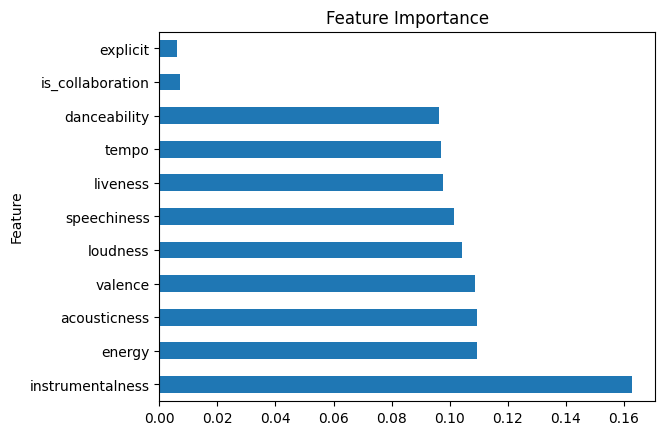

In [18]:
# Feature importance for Random Forest (1:1 Undersampled)
importance = rf_undersampled.feature_importances_
feature_names = X_train_undersampled.columns

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Bar chart
feature_importance_df.plot(kind="barh", x="Feature", y="Importance", legend=False, title="Feature Importance")
plt.show()

#### Feature Importance: XGBoost – Hybrid Dataset

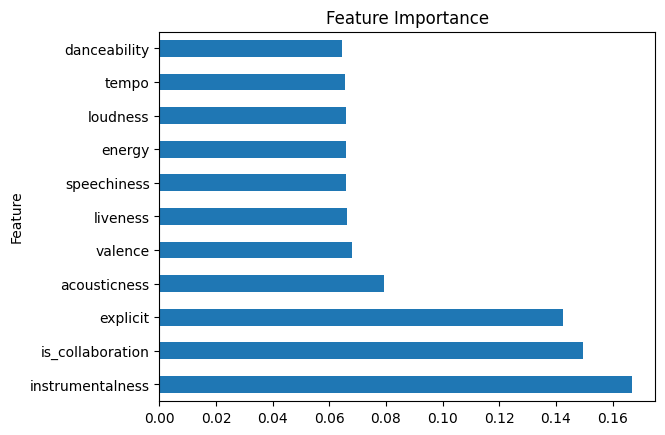

In [19]:
# Feature importance for XGBoost (Hybrid Dataset)
importance = xgb_hybrid_opt.feature_importances_
feature_names = X_train_hybrid.columns

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Bar chart
feature_importance_df.plot(kind="barh", x="Feature", y="Importance", legend=False, title="Feature Importance")
plt.show()

### Confusion Matrices

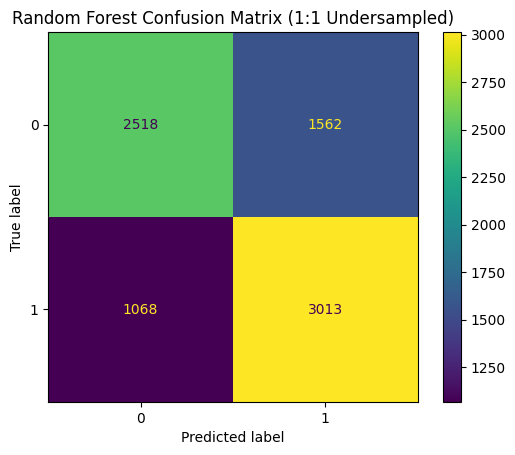

In [15]:
# Confusion matrix for Random Forest (1:1 Undersampled)
ConfusionMatrixDisplay.from_estimator(rf_undersampled, X_test_undersampled, y_test_undersampled)
plt.title("Random Forest Confusion Matrix (1:1 Undersampled)")
plt.show()


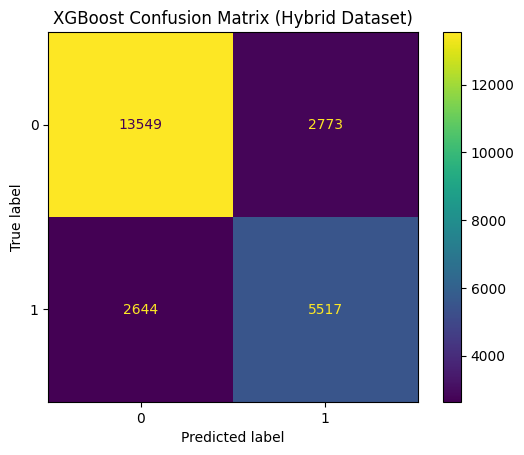

In [16]:
# Confusion matrix for XGBoost (Hybrid Dataset)
ConfusionMatrixDisplay.from_estimator(xgb_hybrid_opt, X_test_hybrid, y_test_hybrid)
plt.title("XGBoost Confusion Matrix (Hybrid Dataset)")
plt.show()


### Final Model Comparison – Precision, Recall, F1-score

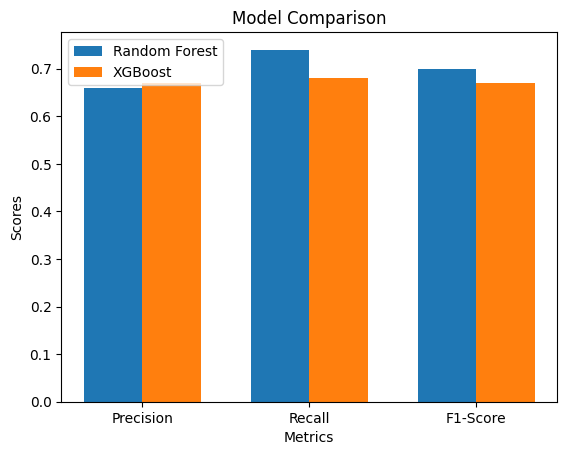

In [17]:
# Defining values
labels = ['Precision', 'Recall', 'F1-Score']
rf_values = [0.66, 0.74, 0.70]
xgb_values = [0.67, 0.68, 0.67]

# Create a simple grouped bar chart using positions [0, 1, 2]
x = [0, 1, 2]
width = 0.35

# Shift bars slightly for comparison
plt.bar([i - width/2 for i in x], rf_values, width, label='Random Forest')
plt.bar([i + width/2 for i in x], xgb_values, width, label='XGBoost')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(x, labels)
plt.legend()
plt.show()